# Clustering de perfiles de OkCupid
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para agrupar perfiles similares de la web de citas OkCupid.

# 1. Setup

Librerías importadas en el proyecto.

In [133]:
import numpy as np
import pandas as pd

import os
from collections import namedtuple

from IPython.display import IFrame

try:
    from geopy.geocoders import Nominatim
except ModuleNotFoundError:
    %pip install geopy
    from geopy.geocoders import Nominatim
    
try:
    import geopandas as gpd
    import shapely
except ModuleNotFoundError:
    %pip install fiona
    %pip install geopandas
    %pip install descartes
    import geopandas as gpd
    import shapely

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, 
    FunctionTransformer,
    OneHotEncoder, OrdinalEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import norm, kstest

Variables globales declaradas en el proyecto.

In [2]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

#!git clone https://github.com/dietrujillo/ml_lab.git ./ml_lab
# os.path.join(os.curdir, "ml_lab", "lab3", "data")  # Path to csv data
DATA_PATH = os.path.join(os.pardir, "data")
# os.path.join(os.curdir, "ml_lab", "lab3", "info")  # Path to problem info
INFO_PATH = os.path.join(os.pardir, "info")
# os.path.join(os.curdir, "ml_lab", "lab3", "results")  # Path to results files
RESULTS_PATH = os.path.join(os.pardir, "results")

Enunciado del problema.

In [3]:
# Jupyter Notebook only
IFrame(os.path.join(INFO_PATH, "lab3.pdf"), width=1080, height=920)

# 2. Análisis exploratorio de los datos

En primer lugar, cargamos los datos en memoria y echamos un primer vistazo.

In [4]:
pd.set_option("display.max_columns", 50)
df = pd.read_csv(os.path.join(DATA_PATH, "okcupid_profiles.csv"))
display(df.iloc[:, :10])
display(df.iloc[:, 10:20])
display(df.iloc[:, 20:31])

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white"
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other"
...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,NaN,NaN,socially,never,graduated from college/university,NaN
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other"
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black"


,height,income,job,last_online,location,offspring,pets,religion,sign,smokes
0,75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes
1,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no
2,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no
3,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no
4,66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no
...,...,...,...,...,...,...,...,...,...,...
59941,62.0,-1,sales / marketing / biz dev,2012-06-12-21-47,"oakland, california",has kids,has dogs,catholicism but not too serious about it,cancer and it&rsquo;s fun to think about,no
59942,72.0,-1,entertainment / media,2012-06-29-11-01,"san francisco, california",doesn't have kids,likes dogs and likes cats,agnosticism,leo but it doesn&rsquo;t matter,no
59943,71.0,100000,construction / craftsmanship,2012-06-27-23-37,"south san francisco, california",doesn't have kids,NaN,christianity but not too serious about it,sagittarius but it doesn&rsquo;t matter,no
59944,73.0,-1,medicine / health,2012-06-23-13-01,"san francisco, california","doesn't have kids, but wants them",likes dogs and likes cats,agnosticism but not too serious about it,leo and it&rsquo;s fun to think about,trying to quit


,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59941,english,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,"my family, my dog, italy, words and music!",writing my book.,"running with my dog, finishing up the work wee...",i have a dream to sing at the alconquin in nyc...,you are seeking a long term connection of shar...
59942,english (fluently),i'm nick. i never know what to write about mys...,currently finishing school for film production...,"filmmaking, photography, graphic design, web d...","dude, i don't know.","movies: hook (the greatest adventure ever!), g...",iphone contact lenses headphones camera tv rem...,i do most of my thinking on the bus to/from wo...,"bringin' home bacon, or drinking and shakin'!",when i was 18 i got a tattoo of waldo somewher...,meh if you made it this far you might as well.
59943,english (fluently),"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively - getting thin...,i'm quiet until i get used to the environment ...,"last book: ""game change"". movies: bourne serie...",- iphone - friends and family - internet - bay...,"aside from work, how to improve my home.",out enjoying friendly conversation over dinner.,please let me think about this more.,we have similar interests.
59944,"english (fluently), spanish (poorly), chinese ...","""all i have in this world are my balls and my ...","following my dreams... ""you got a dream... you...",listening,it used to be the hair until i mowed it off bu...,where to begin musically: right now i listen t...,"music, family, friends, a basketball, hoop, so...",what can i do to make someone chuckle....,what i would do on any other day. everydays a ...,i like walking around in other people's house ...,you are interested and interesting...


Vamos a asegurarnos de que los tipos de datos son los correctos.

In [5]:
pd.DataFrame(df.dtypes)

,0
age,int64
status,object
sex,object
orientation,object
body_type,object
diet,object
drinks,object
drugs,object
education,object
ethnicity,object


Los valores numéricos aparecen como tal. Los valores categóricos o de texto aparecen como `object`, lo cual es aceptable y podemos trabajar con ello. No queremos pasarlo a `str` aún porque puede haber valores `NaN` que se convertirían en el string `'nan'`, y nos daría problemas.

La columna `last_online` es una fecha, y como tal podría convertirse a un tipo `datetime`. Sin embargo, considerando la naturaleza del problema (queremos agrupar perfiles de personalidades similares), creemos que esta columna no será relevante a la hora de decidir si dos personas se parecen. Por eso, vamos a eliminar la columna `last_online`. Con esta decisión reducimos el volumen de datos y nos centramos en las columnas numéricas y categóricas que aportan información sobre la personalidad, preferencias o apariencia física de una persona.

In [6]:
del df["last_online"]

Con respecto al resto de variables, parece que tenemos tres tipos de variables principales: las variables numéricas, las categóricas y las de texto. Consideramos que las de texto son únicamente las variables `essay0`-`essay9`, que son de texto libre puro. Aunque parezca que otras variables de tipo `object` son texto, observando con cuidado se puede ver que todas tienen una cierta estructura (posiblemente sacada de un formulario con un número de opciones finito) y por tanto son categóricas.

In [7]:
numerical_vars = ["age", "height", "income"]
categorical_vars = ["status", "sex", "orientation", "body_type", "diet", "drinks", "drugs", "education",
                    "ethnicity", "job", "location", "offspring", "pets", "religion", "sign", "smokes", "speaks"]
text_vars = [f"essay{i}" for i in range(10)]

Ya que el número de *features* totales es bastante alto, hemos decidido mezclar las fases de análisis y preprocesamiento dividiendo por *feature*. Durante el análisis de una *feature* particular se decidirá cómo preprocesarla y se preparará un transformador que ejecutaremos posteriormente.

Estos transformadores que iremos declarando serán compatibles con la API de *scikit-learn* y por tanto implementarán los métodos `fit` y `transform`. De esta manera conseguimos una estructura modular mantenible. Ejecutaremos el pipeline completo una sola vez, al final del preprocesamiento.

## 2.1 Variables numéricas

En primer lugar vamos a echar un vistazo a los estadísticos descriptivos de las variables numéricas  para después abordar un análisis individual de cada una de ellas.

In [8]:
df[numerical_vars].describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


En este punto ya podemos observar como hay algunos datos numéricos un tanto extraños:
* La altura parece estar en pulgadas, *inches*. La altura media de un ser humano en pulgadas es 68, correspondiente con 172 cm. En este sentido vemos que la altura mínima es 1 pulgada y que la máxima es de 95 (241 cm). Según la lista de personas más altas de la historia publicada en Wikipedia \[1\], una altura de 90 pulgadas (230 cm) ya es algo inaudito. Por otro lado, la altura mínima es 1 pulgada, dato claramente erróneo.
* La edad máxima es 110, lo cual hace dudar que sea un dato correcto. Posiblemente esta edad corresponda con personas que no quieren compartir su edad verdadera.
* Los ingresos llaman la atención en tanto que el ingreso mínimo es -1 y el percentil 75 también es -1. Esto indica que al menos el 75% de los usuarios de la aplicación no han querido decir sus ingresos.

A continuación evaluaremos cada una de estas variables por separado.

### 2.1.1 Altura

#### 2.1.1.1 Análisis de valores nulos

En primer lugar, vamos a ver si tenemos valores nulos en la altura.

In [9]:
any(df["height"].isnull())

True

In [10]:
df[df["height"].isnull()]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
36428,32,single,f,straight,NaN,NaN,NaN,NaN,NaN,other,NaN,-1,artistic / musical / writer,"berkeley, california",NaN,NaN,NaN,NaN,NaN,"english (fluently), german (fluently)",NaN,NaN,NaN,NaN,"thomas bernhard, foucault, annie hall, taxi dr...",NaN,consciousness,NaN,i passionately hate liars!,you know what my user name means and if you ar...
54002,25,single,m,straight,NaN,NaN,NaN,never,NaN,hispanic / latin,NaN,-1,NaN,"guadalajara, mexico",NaN,NaN,NaN,aries,NaN,english,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58983,49,single,m,straight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,"berkeley, california",doesn't have kids,likes cats,NaN,NaN,no,english (fluently),"great guy, lots of positive attributes*, but s...",living it. quite a bit more than that - more ...,"lots, notably good, deep, excellent communicat...","some positive stuff, but i'll hold my tongue o...",lots. not especially up to listing 'em here a...,"1. damn good friend, or better 2. managing to ...",many things. maybe too much. not really up for...,"at the moment, i'd rather not even say or thin...",i have a blog of much that's personal and priv...,you've good reason to think we'd like make at ...


Parece que tenemos tres filas en las cuales nos falta la edad. Podríamos plantearnos utilizar un *imputer* para completar estas filas, pero si miramos el resto de *features* para estos tres individuos vemos que casi todas las columnas están vacías. Habría que rellenar todo con valores neutros, lo cual acabaría añadiendo más ruido que beneficio. Por eso, vamos a eliminar estas tres filas.

In [11]:
df.drop(df[df["height"].isnull()].index, inplace=True)

#### 2.1.1.2 Análisis de valores anómalos

A continuación, vamos a mostrar los datos de la altura recibidos mediante un histograma, así como los valores anómalos (que ya hemos visto que los hay) mediante un diagrama de caja y bigotes.

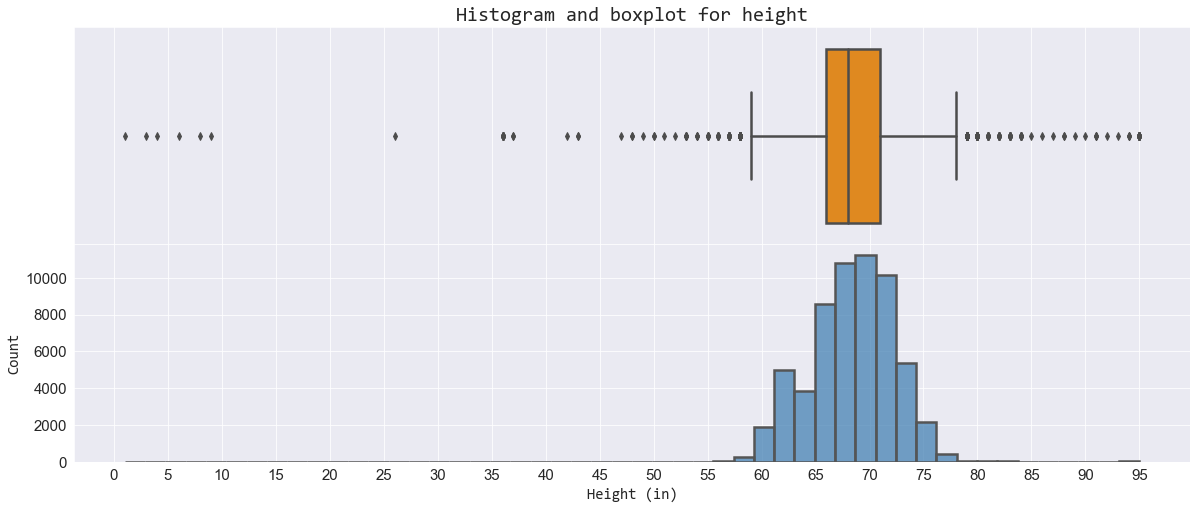

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
plt.subplots_adjust(hspace=0)

sns.boxplot(data=df["height"], orient="horizontal", ax=ax[0], linewidth=2.5, color="darkorange")
ax[0].set_title("Histogram and boxplot for height", fontdict={"size": 20, "family": "Consolas"})
ax[0].set_yticks([])

sns.histplot(data=df["height"], bins=50, ax=ax[1], linewidth=2.5, edgecolor="#555555", color="steelblue")
ax[1].set_xticks(range(0, 100, 5))
ax[1].set_xlabel("Height (in)", fontdict={"size": 15, "family": "Consolas"})
ax[1].set_ylabel("Count", fontdict={"size": 15, "family": "Consolas"})


plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

Podemos observar que los valores anómalos son abundantes en este caso. Vamos a ver qué valores son:

In [13]:
df[df["height"] > np.percentile(df["height"], 75)]["height"].value_counts().sort_index()

72.0    5315
73.0    2815
74.0    2547
75.0    1382
76.0     783
77.0     280
78.0     132
79.0      57
80.0      27
81.0      11
82.0      11
83.0      12
84.0       9
85.0       1
86.0       1
87.0       1
88.0       2
89.0       1
90.0       1
91.0       3
92.0       1
93.0       1
94.0       3
95.0      20
Name: height, dtype: int64

In [14]:
df[df["height"] > 85]["sex"].value_counts()

m    24
f    10
Name: sex, dtype: int64

En el caso de las personas muy altas, las alturas de 72-79 pulgadas (182-200 cm) parecen valores anómalos pero correctos, atendiendo al alto número de instancias. Por otra parte, hay 20 instancias que han dado 95 pulgadas, lo cual nos hace pensar que probablemente era el máximo valor permitido en el formulario y ha sido seleccionado por usuarios que han hecho cuentas falsas. Podemos tomar la decisión de eliminar las filas con alturas mayores de 85 pulgadas (215 cm). Las probabilidades de que sean valores reales son muy bajas en el caso de hombres, y sólo hay una mujer viva en el mundo que mida más de 215 cm, Sun Fang de China \[1\]. Por ello, eliminamos estos registros.

In [15]:
df.drop(df[df["height"] > 85].index, inplace=True)

Ahora abordaremos el caso contrario, el de las personas que no llegan al percentil 25 de altura.

In [16]:
df[df["height"] < np.percentile(df["height"], 25)]["height"].value_counts().sort_index(ascending=False)

65.0    3794
64.0    3865
63.0    2767
62.0    2244
61.0    1090
60.0     791
59.0     212
58.0      53
57.0      17
56.0       8
55.0       6
54.0       3
53.0       5
52.0       1
51.0       1
50.0       2
49.0       1
48.0       2
47.0       1
43.0       2
42.0       1
37.0       2
36.0      11
26.0       1
9.0        1
8.0        1
6.0        1
4.0        1
3.0        1
1.0        1
Name: height, dtype: int64

De nuevo, estamos ante una situación similar: la mayoría de valores anómalos están más cerca de la mediana que del mínimo. Aquí podemos establecer un límite inferior coherente de acuerdo con el diagrama de caja y bigotes y partiendo de la base de que podemos contar con usuarios de la aplicación que pueden tener alguna patología como el enanismo. Según Mayo Clinic \[2\], una persona que padezca enanismo podría estar entorno a 122 cm de altura (48 pulgadas), existiendo algunos casos que pueden alcanzar los 91 (35.8 pulgadas) en casos muy raros. Por ello, vamos a eliminar los registros con valores inferiores a 36.

In [17]:
df.drop(df[df["height"] < 36].index, inplace=True)

#### 2.1.1.3 Análisis de normalidad

Una vez hemos tratado los valores erróneos, el preprocesamiento de la altura será una normalización o escalado. Vamos a hacer una comprobación de normalidad.

In [18]:
mu, sigma = norm.fit(df["height"])
n = norm(loc=mu, scale=sigma)
pvalue = kstest(df["height"], n.cdf).pvalue
if pvalue < 0.05:
    print(f"Not a normal distribution. p-value: {pvalue}")
else:
    print("Test inconclusive")

Not a normal distribution. p-value: 1.333621726087334e-294


Parece que el test dice que la variable no sigue una distribución normal. Sin embargo, vamos a volver a mirar el histograma después de haber eliminado los valores erróneos.

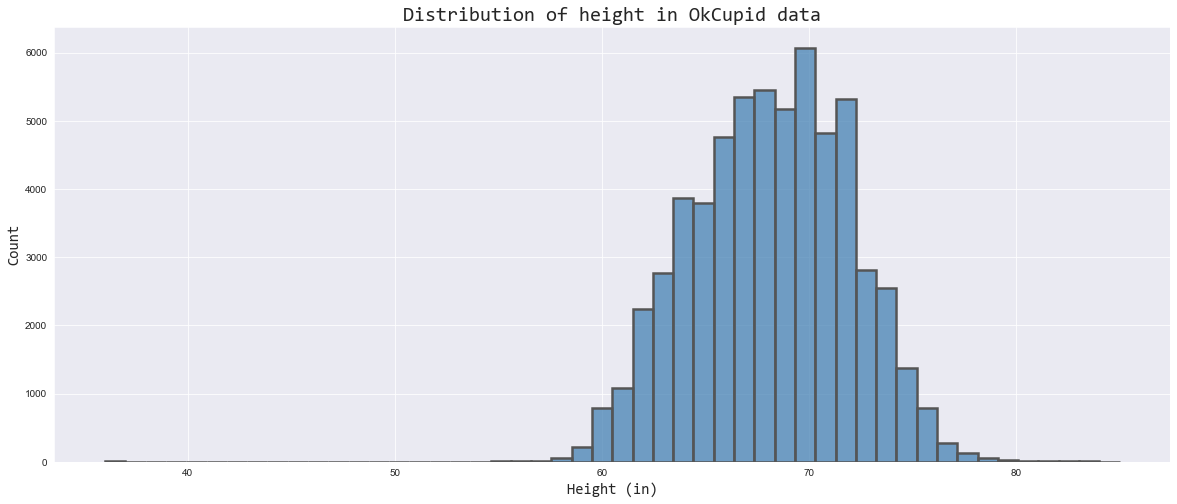

In [19]:
plt.figure(figsize=(20, 8))
plt.title("Distribution of height in OkCupid data", fontdict={"size": 20, "family": "Consolas"})
sns.histplot(data=df["height"], bins=50, linewidth=2.5, edgecolor="#555555", color="steelblue")
plt.xlabel("Height (in)", fontdict={"size": 15, "family": "Consolas"})
plt.ylabel("Count", fontdict={"size": 15, "family": "Consolas"})
plt.show()

Claramente el test $K$-$S$ ha dicho que no es una distribución normal por los valores anómalos de alturas menores de 40 pulgadas. Esto también significa que un escalado normal entre 0 y 1 sería una mala idea, ya que si 36 pulgadas es el mínimo, la mayoría de valores acabarán escalados alrededor de 0.75.

La altura humana es considerada a menudo como el ejemplo clásico de variable normal, y tomando como referencia datos del Centro de Control de Enfermedades de E.E.U.U. (CDC \[3\]) vemos que en las distribuciones de la altura la mediana es siempre igual a la media y la separación entre cuantiles es constante, factores que son suficientes para utilizar una normalización sin problemas.

#### 2.1.1.4 Transformador

Ahora que hemos estudiado la normalidad de la distribución, podemos definir un [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) para la variable `height`.

In [20]:
height_transformer = StandardScaler()

### 2.1.2 Edad

#### 2.1.2.1 Análisis de valores nulos

Vamos a ver si hay valores nulos para la edad, y si los hay, cuántos son.

In [21]:
any(df["age"].isnull())

False

Por suerte este campo no tiene valores nulos. Probablemente esto se deba a que para poder utilizar la plataforma de OkCupid, tener una edad mayor a 18 es un requisito, y por tanto incluir la edad es obligatorio.

#### 2.1.2.2 Análisis de valores anómalos

Como hemos visto anteriormente, hay una edad máxima de 110 años. Lo más seguro es que se trate de un dato erróneo, así que vamos a estudiar estos valores anómalos con un diagrama de caja y bigotes junto a un histograma.

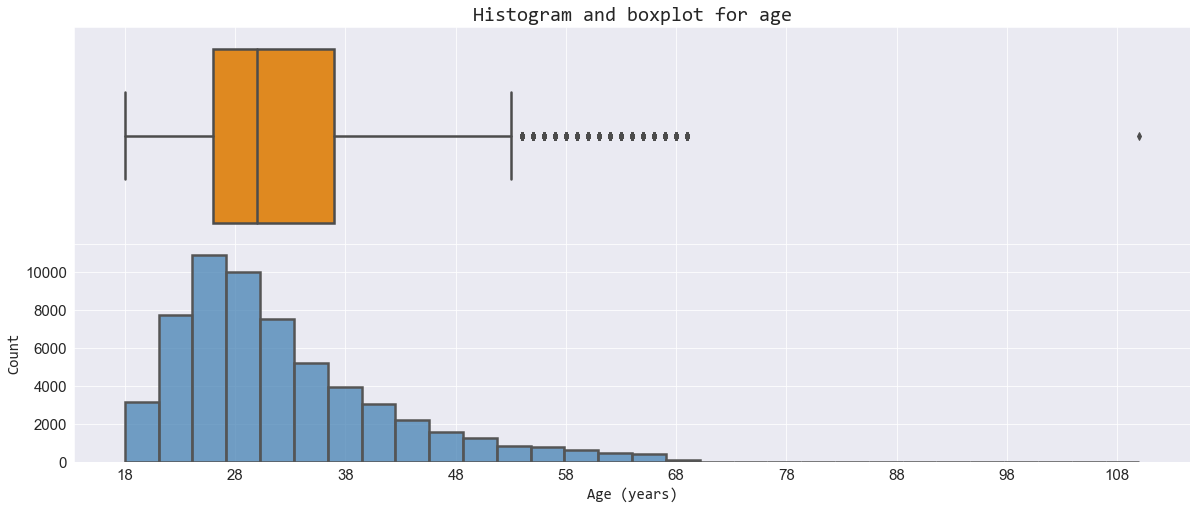

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
plt.subplots_adjust(hspace=0)

sns.boxplot(data=df["age"], orient="horizontal", ax=ax[0], linewidth=2.5, color="darkorange")
ax[0].set_title("Histogram and boxplot for age", fontdict={"size": 20, "family": "Consolas"})
ax[0].set_yticks([])

sns.histplot(data=df["age"], bins=30, ax=ax[1], linewidth=2.5, edgecolor="#555555", color="steelblue")
ax[1].set_xticks(range(18, 110, 10))
ax[1].set_xlabel("Age (years)", fontdict={"size": 15, "family": "Consolas"})
ax[1].set_ylabel("Count", fontdict={"size": 15, "family": "Consolas"})


plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

En este caso, parece que los valores anómalos no son tantos, y parecen ser razonables, exceptuando ese 110 que veíamos al principio. Vamos a mirar los valores superiores al percentil 75.

In [23]:
df[df["age"] > np.percentile(df["age"], 75)]["age"].value_counts().sort_index()

38     1329
39     1171
40     1029
41      979
42     1072
43      858
44      708
45      643
46      578
47      529
48      481
49      458
50      437
51      350
52      343
53      252
54      267
55      264
56      271
57      256
58      197
59      221
60      195
61      175
62      167
63      138
64      113
65      109
66      105
67       66
68       59
69       31
110       1
Name: age, dtype: int64

Sin tener nada más en lo que apoyarnos, parece creíble que todos los valores anómalos sean reales, exceptuando el de 110. Vamos a mirar bien esa fila:

In [24]:
df[df["age"] == 110]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
2512,110,single,f,straight,NaN,NaN,NaN,NaN,NaN,NaN,67.0,-1,NaN,"daly city, california",NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Claramente este usuario no es serio. De lo contrario, habría rellenado algún campo más. 

Sólo para asegurarnos y dejarlo aún más claro, podemos apoyarnos en la tabla de la Administración de la Seguridad Social de E.E.U.U (SSA \[4\]), que nos dice la probabilidad de muerte dada una edad. El apartado *Number of lives* indica el número de personas que sobreviven hasta la edad dada partiendo de 100000. Para 110 años, son 14. Si la probabilidad de que una persona dada tenga 110 años o más es $0.00014$, sin considerar las probabilidades de que esté utilizando una red de citas (dudosas en el mejor de los casos), podemos eliminar esta fila sin dudas.

In [25]:
df.drop(df[df["age"] == 110].index, inplace=True)

#### 2.1.2.3 Transformador

Con respecto al resto de datos, claramente no están distribuidos de forma normal. Podemos simplemente codificar utilizando un escalado de 0 a 1.

In [26]:
age_transformer = MinMaxScaler()

### 2.1.3 Ingresos

#### 2.1.3.1 Análisis de valores nulos

Como hemos hecho en las demás variables numéricas, vamos a estudiar si hay valores nulos.

In [27]:
any(df["income"].isnull())

False

En principio parece no haber valores nulos. Sin embargo, hemos observado anteriormente que la gran mayoría de valores son un -1, indicando que no se ha querido decir los ingresos. Si consideramos estos valores como nulos, tendremos un porcentaje alto.

In [28]:
print(f"{round((len(df[df['income'] == -1]) / len(df)) * 100)}% with non-specified incomes")

81% with non-specified incomes


Este valor es excesivamente alto. No podemos utilizar un *imputer* para completar estos valores. Tampoco podemos eliminar las filas que hayan indicado -1 en `income`, porque perderíamos el $81\%$ de nuestros datos. Ante esta situación, lo mejor que podemos hacer es eliminar la columna `income` al completo. Tenemos otras variables, como la ocupación, que pueden servir de sustituto para reflejar el poder adquisitivo de un usuario, y esta columna está demasiado vacía para ser usable.

In [29]:
df.drop(columns="income", inplace=True)

## 2.2 Variables categóricas

Antes de empezar con las variables categóricas específicas, podemos echar un vistazo general para ver si podemos encontrar patrones interesantes.

In [30]:
df[categorical_vars]

,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,job,location,offspring,pets,religion,sign,smokes,speaks
0,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",transportation,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english
1,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,hospitality / travel,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (..."
2,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,NaN,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no,"english, french, c++"
3,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,student,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no,"english, german (poorly)"
4,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",artistic / musical / writer,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no,english
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,single,f,straight,NaN,NaN,socially,never,graduated from college/university,NaN,sales / marketing / biz dev,"oakland, california",has kids,has dogs,catholicism but not too serious about it,cancer and it&rsquo;s fun to think about,no,english
59942,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other",entertainment / media,"san francisco, california",doesn't have kids,likes dogs and likes cats,agnosticism,leo but it doesn&rsquo;t matter,no,english (fluently)
59943,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian,construction / craftsmanship,"south san francisco, california",doesn't have kids,NaN,christianity but not too serious about it,sagittarius but it doesn&rsquo;t matter,no,english (fluently)
59944,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black",medicine / health,"san francisco, california","doesn't have kids, but wants them",likes dogs and likes cats,agnosticism but not too serious about it,leo and it&rsquo;s fun to think about,trying to quit,"english (fluently), spanish (poorly), chinese ..."


Llegados a este punto, hemos decidido subdividir las variables categóricas en tres tipos:
 1. Las variables categóricas simples (una cadena de caracteres $\iff$ una categoría)
 2. Las variables que van a resultar en un punto de un espacio de $n$ dimensiones (por ejemplo, descompondremos `location` en dos dimensiones `latitude` y `longitude`).
 3. Las variables que contienen un conjunto de categorías estándar modificadas por prefijos o sufijos (como las dietas)
 
Trataremos cada conjunto de variables por separado.

### 2.2.1 Variables categóricas simples

Estas variables simples son aquellas en las que una entrada implica una categoría. Acabarán codificadas como un vector one-hot utilizando [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) o de forma ordinal utilizando [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Estas variables son `status`, `sex`, `drinks`, `drugs`, `job` y `smokes`.

Sin embargo, es posible que necesiten algún preprocesamiento anterior. En muchos casos parece que algunas categorías pueden agruparse, como es el caso de algunos tipos de `status`. Para estos casos, vamos a preparar un transformador (o mejor dicho, un conjunto de transformadores) que nos permitirá modificar estas entradas fácilmente.

In [31]:
def substitution_transformer(substitution_dict, full=False):
    """
    Substitute elements of a NumPy array.
    
    substitution_dict: dictionary with shape {oldvalue1: newvalue1, oldvalue2: newvalue2, ... }
    full: whether to substitute entire entry if a key matches or substitute just the match
    """
    def substitute_elements(X):
        for old, new in substitution_dict.items():
            if full:
                replacer = np.vectorize(lambda x: new if old in x else x)
            else:
                replacer = np.vectorize(lambda x: x.replace(old, new))
            X = np.array(replacer(X), dtype=object)
        return X
    
    return FunctionTransformer(substitute_elements)

Con esto listo, vamos a empezar a estudiar las variables.

#### 2.2.1.1 Estado marital

In [32]:
df["status"].value_counts(dropna=False)

single            55657
seeing someone     2062
available          1863
married             309
unknown              10
Name: status, dtype: int64

Estos posibles estados parecen ser compatibles entre sí. Asumimos que el estado `unknown` significa que el usuario ha preferido no decirlo, no que sea un tipo diferente. Vamos a ver qué filas tienen `unknown`.

In [33]:
df[df["status"] == "unknown"]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,job,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
17337,57,unknown,m,gay,average,mostly anything,rarely,NaN,graduated from high school,white,70.0,retired,"menlo park, california",doesn't want kids,likes dogs and likes cats,other,leo,no,"english, english",as an artist i like to borrow images that i li...,filling life with as much colour as i can.,spinning records & dabbing brushes.,i have an assortment of hand-painted shirts i ...,"books ----- frank herbert, clive barker, verno...","family the newest member of my family ""dances ...",i love brian eno's idea of the happy accident.,"at home with my boy friend usually, listening ...",paisley hankys are on the right side.,if you are a character of interest ? drop a line.
20367,38,unknown,m,straight,average,NaN,socially,NaN,NaN,NaN,68.0,NaN,"oakland, california",NaN,NaN,NaN,NaN,NaN,english,fun loving professional guy. i live in oakland...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i have watched late-night nanny marathons (or ...,NaN
31148,31,unknown,m,straight,athletic,NaN,socially,never,working on masters program,asian,69.0,sales / marketing / biz dev,"san francisco, california",NaN,NaN,NaN,aquarius,no,"english (okay), chinese (okay), spanish (okay)...",believing that anything can happen. or just tr...,social entrepreneur + product marketer,"balancing a spoon on my nose, making monkey fa...",big eyes,"favorite- books: ""leaving microsoft to change ...",motivation creativity oxygen ideas mobility/ t...,-how to improve socioeconomic conditions in de...,"out to dinner/ drinks with friends, movie...",my favorite routine: shopping for food at trad...,"...you want to chat, hang out, and learn about..."
32848,38,unknown,m,straight,NaN,NaN,socially,NaN,graduated from college/university,NaN,74.0,computer / hardware / software,"san francisco, california",NaN,NaN,NaN,aries and it&rsquo;s fun to think about,no,"english (fluently), french","i'm easy going, funny, and don't do anything h...",i'm an independent consultant. i mostly work w...,"cooking from scratch, making a great coffee, p...",my eyes and my smile,"a: most anything by asimov, dune, tolkien, bol...","sushi, coffee, bread, beer, music, books",NaN,what's typical about friday night? sometimes i...,NaN,NaN
38009,27,unknown,f,straight,NaN,NaN,rarely,never,working on college/university,white,64.0,artistic / musical / writer,"san francisco, california",NaN,has dogs and has cats,agnosticism and laughing about it,scorpio but it doesn&rsquo;t matter,no,"english (fluently), irish (fluently), chinese ...","hi there! i'm new here, and looking to make so...","right now, i am pursuing a degree in anthropol...","listening, playing music, cooking, helping peo...","my warped sense of humor, my clothing (i'm a h...","books: o'neill's music of ireland, last night'...","my flute, my laptop, my friends, cheese, my fa...","our insignificance in the universe, our possib...",playing a gig with bandmates or listening to a...,"i have a morbid phobia of writing. yes, yes, y...","you like pie, you like world music, you're eas..."
42771,37,unknown,m,straight,average,mostly anything,socially,never,dropped out of college/university,asian,66.0,computer / hardware / software,"berkeley, california",NaN,likes dogs and likes cats,buddhism but not too serious about it,pisces but it doesn&rsquo;t matter,no,"english (fluently), german (okay), japanese (o...",um. hi. i'm pretty bad at filling out these th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45885,22,unknown,f,straight,curvy,mostly anything,socially,never,NaN,other,61.0,other,"walnut creek, california",doesn't want kids,has dogs and likes cats,NaN,leo and it&rsquo;s fun to think about,no,"english (fluently), japanese (poorly), spanish...",i decided it was about time to change this. al...,graduated from culinary school with a baking a...,talking and listening. believe me they go

Parece que estos perfiles son serios, lo cual hace que nos cueste eliminarlos. Lo que haremos será tratar `unknown` para que el one-hot devuelva un vector vacío (completo con ceros).

Por otra parte, vamos a considerar que los estados `single` y `available` son sinónimos. Es posible que haya relaciones abiertas o algo similar, pero este tipo de relaciones no son tan comunes como para abarcar un porcentaje tan alto de los datos. Por eso unificaremos estas dos categorías utilizando el `substitution_transformer`.

Vamos a preparar un transformador para implementar estos detalles que hemos mencionado:

In [34]:
df["status"] = df["status"].astype(object)
status_transformer = Pipeline([
    ("available_to_single", substitution_transformer({"available": "single"})),
    ("one_hot", OneHotEncoder(categories=[["single", "seeing someone", "married"]], handle_unknown="ignore"))
])

#### 2.2.1.2 Sexo

A continuación estudiaremos el sexo de los usuarios.

In [35]:
df["sex"].value_counts(dropna=False)

m    35799
f    24102
Name: sex, dtype: int64

Parece que no hay valores nulos, lo cual es positivo. Esta variable se puede codificar simplemente como 0 si hombre y 1 si mujer, o viceversa.

In [36]:
sex_transformer = OrdinalEncoder(categories=[["m", "f"]])

#### 2.2.1.3 Bebida

Lo primero es ver qué tipos tenemos.

In [37]:
df["drinks"].value_counts(dropna=False)

socially       41764
rarely          5955
often           5157
not at all      3264
NaN             2975
very often       469
desperately      317
Name: drinks, dtype: int64

Este parece un ejemplo claro de variable ordinal. Si ordenamos las categorías y consideramos que `NaN` significa algo promedio (no podemos asumir nada más), podemos desarrollar un transformador simple que codifique la variable como ordinal.

Después de la codificación ordinal, deberemos escalar al rango 0-1, ya que una normalización no será acertada.

In [38]:
df["drinks"] = df["drinks"].astype(str).astype(object)  # Needed to convert np.nan to string "nan"
drinks_transformer = Pipeline([
    ("nan_to_socially", substitution_transformer({"nan": "socially"})),
    ("encoder", OrdinalEncoder(categories=[["not at all", "rarely", "socially", "often", "very often", "desperately"]])),
    ("scaler", MinMaxScaler())
])

#### 2.2.1.4 Drogas

Como siempre, echamos un primer vistazo a las categorías.

In [39]:
df["drugs"].value_counts(dropna=False)

never        37704
NaN          14066
sometimes     7726
often          405
Name: drugs, dtype: int64

En este caso vamos a codificar la variable también de forma ordinal, con la distinción de que los valores `NaN` quedarán colocados entre `never` y `sometimes`. Hacemos esto porque creemos que los valores `NaN` pueden deberse a gente que ha tomado drogas en el pasado, pero ya no lo hace y prefiere no contestar a escribir `sometimes`. Es una posibilidad que hace que sea mala idea sustituir `NaN` con `sometimes`.

In [40]:
df["drugs"] = df["drugs"].astype(str).astype(object)  # Needed to convert np.nan to string "nan"
drugs_transformer = Pipeline([
    ("encoder", OrdinalEncoder(categories=[["never", "nan", "sometimes", "often"]])),
    ("scaler", MinMaxScaler())
])

#### 2.2.1.5 Ocupación laboral

In [41]:
df["job"].value_counts(dropna=False)

NaN                                  8185
other                                7584
student                              4878
science / tech / engineering         4845
computer / hardware / software       4706
artistic / musical / writer          4435
sales / marketing / biz dev          4390
medicine / health                    3679
education / academia                 3511
executive / management               2373
banking / financial / real estate    2265
entertainment / media                2249
law / legal services                 1380
hospitality / travel                 1364
construction / craftsmanship         1020
clerical / administrative             805
political / government                708
rather not say                        433
transportation                        366
unemployed                            272
retired                               250
military                              203
Name: job, dtype: int64

Esta variable se codificará con un `OneHotEncoder`. Los valores nulos en este caso se tratarán como los valores `other`: se devolverá un vector de ceros vacío.

In [42]:
df["job"] = df["job"].astype(str).astype(object)  # Needed to convert np.nan to string "nan"

job_transformer = Pipeline([
    ("nan_to_other", substitution_transformer({"nan": "other"})),
    ("encoder", OneHotEncoder(drop=[["other"]]))
])

#### 2.2.1.6 Tabaco

Como siempre, empezamos observando los posibles valores de la variable.

In [43]:
df["smokes"].value_counts(dropna=False)

no                43874
NaN                5501
sometimes          3785
when drinking      3035
yes                2226
trying to quit     1480
Name: smokes, dtype: int64

Este caso es similar a `drugs`, con algunas diferencias:
- Vamos a unificar `when drinking` y `sometimes` porque los consideramos sinónimos.
- Vamos a completar los valores `NaN` con `sometimes` (asumiendo que si alguien no fuma, habría contestado `no`).
- Vamos a hacer que `trying to quit` sea igual a `sometimes`, con la idea de que alguien que está intentando dejar el tabaco está a medio camino de alguien que fuma habitualmente y alguien que no.

In [44]:
df["smokes"] = df["smokes"].astype(str).astype(object)  # Needed to convert np.nan to string "nan"
smokes_transformer = Pipeline([
    ("category_merger", substitution_transformer({"nan": "sometimes", "when drinking": "sometimes", "trying to quit": "sometimes"})),
    ("encoder", OrdinalEncoder(categories=[["no", "sometimes", "yes"]])),
    ("scaler", MinMaxScaler())
])

### 2.2.2 Variables categóricas multidimensionales

Este apartado se refiere a variables categóricas que se van a codificar como puntos de un espacio vectorial de varias dimensiones. Un ejemplo es la localización geográfica, que convertiremos en dos variables de latitud y longitud. Esto se hará para mantener las distancias entre instancias similares. Por ejemplo, un usuario de California puede estar a la misma latitud que alguien de España, pero evidentemente está mucho más lejos que de un usuario de Nueva York, donde ni la latitud ni la longitud están cerca. Es la combinación de las variables la que da una medición precisa.

Las variables multidimensionales son `orientation`, `body_type`, `location`, `offspring` y `pets`.

La forma unificada de codificar estas variables se hará mediante un diccionario que convertirá un *string* (categoría) dado en una tupla que representará el punto en cuestión. Una vez se tenga el diccionario, se generará un transformador de `sklearn` con la siguiente función:

In [45]:
def category_to_point_transformer(transformer_dict):
    
    def transform(X):
        assert len(X.shape) == 2
        assert X.shape[-1] == 1, "Use this transformer on single features only."
        if type(X) is pd.DataFrame:
            X = X.to_numpy()
        X = X[:, 0]
        
        output_shape = len(list(transformer_dict.values())[0])
        assert all([len(x) == output_shape for x in transformer_dict.values()])
        
        ret = np.zeros((len(X), output_shape), dtype=float)
        for i in range(len(X)):
            row = []
            for j in range(output_shape):
                row.append(transformer_dict[X[i]][j])
            ret[i] = np.array(row)
            
        return ret
    
    return FunctionTransformer(transform)

#### 2.2.2.1 Orientación sexual

Lo primero que hacemos es ver qué tipos de variables tenemos.

In [46]:
df["orientation"].value_counts(dropna=False)

straight    51564
gay          5572
bisexual     2765
Name: orientation, dtype: int64

Para este caso, queremos representar la orientación sexual con dos variables `likes_men` y `likes_women`. Creemos que es una idea más acertada que simplemente codificar como one-hot, o como un valor que vaya de 0 a 1 (con 0.5 si es `bisexual`), ya que entendemos que las categorías de `straight` y `gay` no significan lo mismo si hablamos de un hombre que si hablamos de una mujer. Por eso, lo primero que vamos a hacer es añadir el sexo de la persona como parte de la columna `orientation`, a fin de facilitar el preprocesamiento más adelante.

In [47]:
df["orientation"] = df["orientation"] + " " + df["sex"]
df["orientation"].sample(n=5, random_state=RANDOM_SEED)

37988    straight f
53353    straight m
18781    straight f
28027    straight f
34819    straight f
Name: orientation, dtype: object

A continuación preparamos un diccionario que nos dé los resultados esperados.

In [48]:
# Orientation tuple: (likes_men, likes_women)
orientation_dict = {
    "gay f": (0, 1),
    "gay m": (1, 0),
    "straight f": (1, 0),
    "straight m": (0, 1),
    "bisexual f": (1, 1),
    "bisexual m": (1, 1)
}

In [49]:
all([x in orientation_dict.keys() for x in df["orientation"]])

True

Ahora sólo falta preparar el transformador para la etapa de preprocesamiento.

In [50]:
orientation_transformer = category_to_point_transformer(orientation_dict)

#### 2.2.2.2 Complexión corporal

Observamos antes de nada los tipos con los que trabajamos.

In [51]:
df["body_type"].value_counts(dropna=False)

average           14651
fit               12708
athletic          11809
NaN                5283
thin               4710
curvy              3923
a little extra     2629
skinny             1777
full figured       1009
overweight          442
jacked              413
used up             350
rather not say      197
Name: body_type, dtype: int64

En este caso es evidente que podemos unificar muchos de los tipos. Nos hemos planteado tratarlo como un punto de $n$ dimensiones por dos motivos:
- Primero, una codificación one-hot no sería realista incluso después de unificar los elementos similares. Codificar las categorías como vectores perpendiculares entre sí conseguiría que la distancia entre `skinny` y `average` fuera la misma que la distancia entre `skinny` y `overweight`, por ejemplo.
- Segundo, una codificación ordinal desperdiciaría mucha información, ya que hay varias escalas en las que se pueden ordenar las categorías.

Cada una de estas escalas será una dimensión del espacio de codificación. Estas escalas serán el peso relativo y el atletismo relativo (cuerpo más o menos definido) y tomarán valores entre 0 y 1.

En los casos `rather not say` y `NaN`, no podemos hacer más que considerarlos `average`.

In [52]:
df["body_type"] = df["body_type"].astype(str).astype(object)

# Body type tuple: (weight, athletism)
body_type_dict = {
    "average": (0.5, 0.5),
    "nan": (0.5, 0.5),
    "rather not say": (0.5, 0.5),
    
    "skinny": (0, 0),
    "thin": (0.25, 0.5),
    
    "curvy": (0.75, 0.5),
    "a little extra": (0.75, 0.5),
    "full figured": (0.75, 0.5),
    "overweight": (1, 0),
    
    "fit": (0.5, 1),
    "athletic": (0.5, 1),
    "jacked": (1, 1),
    
    "used up": (0.5, 0)
}

In [53]:
all([x in body_type_dict.keys() for x in df["body_type"]])

True

Sólo queda preparar el transformador usando `category_to_point_transformer`.

In [54]:
body_type_transformer = category_to_point_transformer(body_type_dict)

#### 2.2.2.3 Localización geográfica

In [55]:
df["location"].value_counts(dropna=False)

san francisco, california      31043
oakland, california             7210
berkeley, california            4206
san mateo, california           1329
palo alto, california           1063
                               ...  
seaside, california                1
south orange, new jersey           1
north hollywood, california        1
glencove, california               1
vacaville, california              1
Name: location, Length: 198, dtype: int64

In [56]:
any(df["location"].isnull())

False

En este caso, parece que tenemos localizaciones en forma de *strings* que siguen el formato \[ciudad\], \[estado\]. En el caso de E.E.U.U parece que sí es el estado, mientras que en el resto de países es el nombre del país. Debemos comprobar que este formato está compartido por todos los elementos de la serie.

In [57]:
all(df["location"].apply(lambda x: x.count(",") == 1))

False

In [58]:
df["location"][df["location"].apply(lambda x: x.count(",") != 1)]

42438    vancouver, british columbia, canada
Name: location, dtype: object

Parece que hay una sola fila en la que tenemos tres valores separados por comas. Esto es comprensible si pensamos que Canadá también tiene estados que funcionan bajo un gobierno federal. Sólo es una instancia, pero no tenemos por qué eliminarla del dataset si no es necesario (hay usuarios en Seattle, por ejemplo, que está relativamente cerca de Vancouver). Podemos modificarla para que se adapte al formato sin más.

In [59]:
vancouver_id = df["location"][df["location"].apply(lambda x: x.count(",") != 1)].index[0]
df.at[vancouver_id, "location"] = "vancouver, canada"

In [60]:
all(df["location"].apply(lambda x: x.count(",") == 1))

True

Ahora que parece que todo está en el mismo formato, vamos a codificar la localización en latitud y longitud. Para ello utilizaremos la clase [`Nominatim`](https://geopy.readthedocs.io/en/stable/#nominatim) de `geopy`.

In [61]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
    
location_dict = {}
for location in df["location"].unique():
    geocode = geolocator.geocode(location)
    location_dict[location] = (geocode.latitude, geocode.longitude)
        
for location in df["location"].unique()[:5]:
    print(location, location_dict[location][0], location_dict[location][1])

south san francisco, california 37.6535403 -122.4168664
oakland, california 37.8044557 -122.2713563
san francisco, california 37.7790262 -122.4199061
berkeley, california 37.8708393 -122.2728639
belvedere tiburon, california 37.8771208 -122.4616696


Para asegurarnos de que no hay errores, en lugar de ir comprobando los datos uno a uno podemos simplemente mostrar una imagen con las localizaciones en un mapa. Utilizamos una escala logarítmica para visualizar bien las diferencias entre puntos.

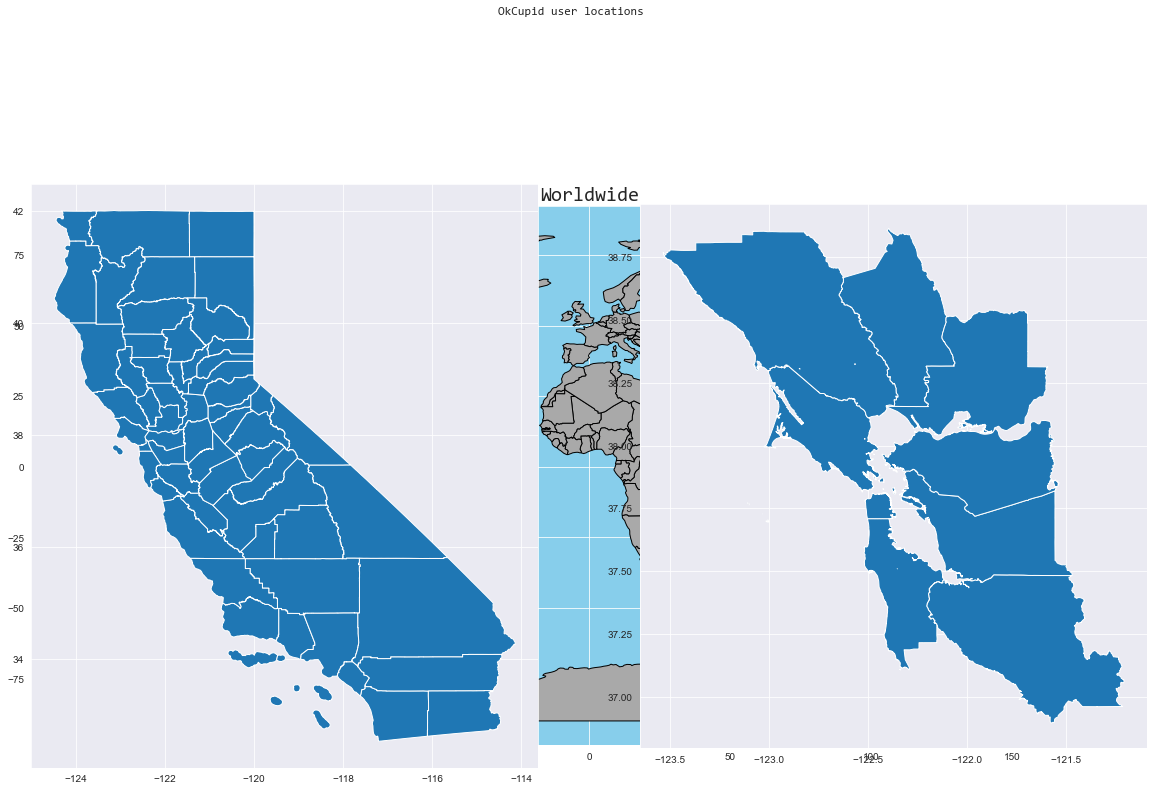

In [148]:
fig = plt.figure(figsize=(20, 24))
fig.suptitle("OkCupid user locations", fontdict={"size": 20, "family": "Consolas"})

# Define user locations
geometry = [shapely.geometry.Point(lon, lat) for lat, lon in location_dict.values()]
locations = gpd.GeoDataFrame({"location": location_dict.keys()}, geometry=geometry)
counts = df["location"].value_counts()
locations["count"] = [counts.loc[x] for x in location_dict.keys()]

# Define log scale
norm = LogNorm(vmin=locations["count"].min(), vmax=locations["count"].max())
locations["count_log"] = norm(locations["count"] + 1)


outer = gridspec.GridSpec(2, 1)
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig, inner[0])
fig.add_subplot(ax)

# Plot world map
ax.set_facecolor("skyblue")
ax.set_title("Worldwide", fontdict={"size": 20, "family": "Consolas"})
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot(#column="iso_a3",
           ax=ax,
           color="darkgray",
           alpha=1,
           linewidth=1,
           edgecolor="black")

inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0])

ax = plt.Subplot(fig, inner[0])
fig.add_subplot(ax)
california.plot(ax=ax)

ax = plt.Subplot(fig, inner[1])
fig.add_subplot(ax)
bay_area.plot(ax=ax)

plt.show()

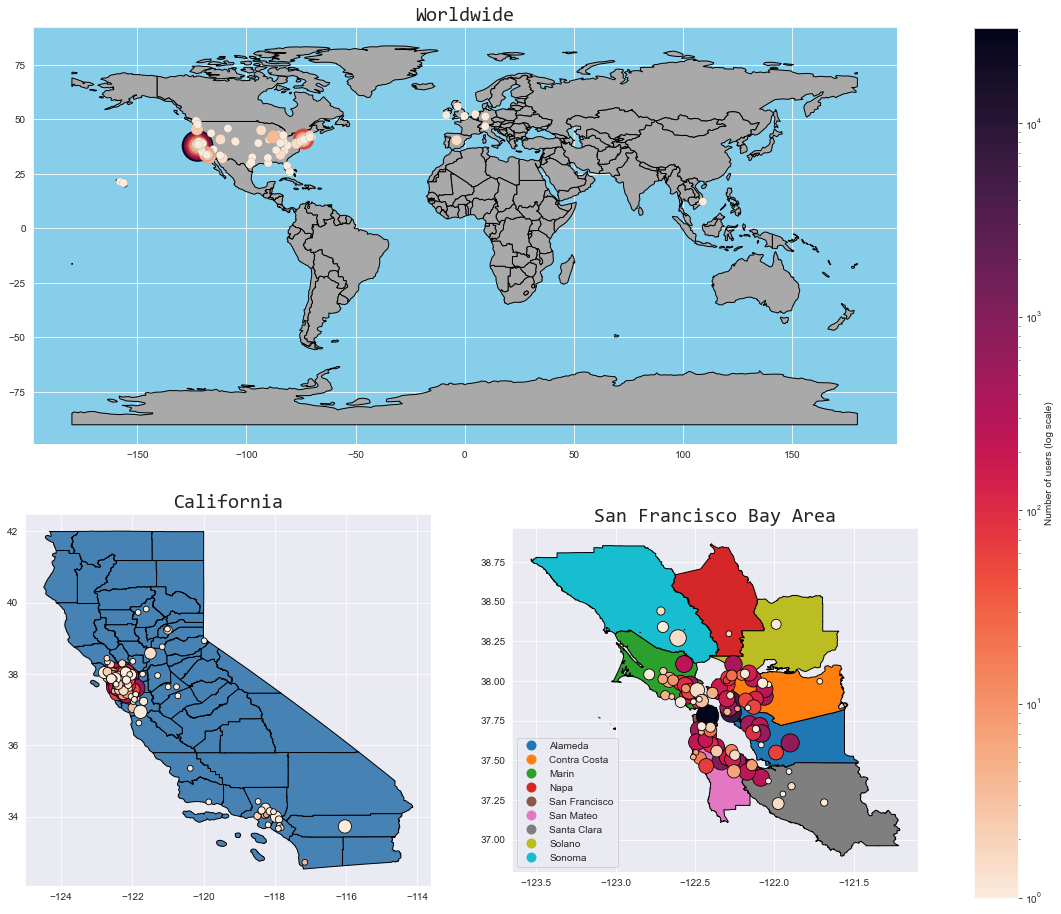

In [188]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# Define user locations
geometry = [shapely.geometry.Point(lon, lat) for lat, lon in location_dict.values()]
locations = gpd.GeoDataFrame({"location": location_dict.keys()}, geometry=geometry)
counts = df["location"].value_counts()
locations["count"] = [counts.loc[x] for x in location_dict.keys()]

# Define log scale
norm = LogNorm(vmin=locations["count"].min(), vmax=locations["count"].max())
locations["count_log"] = norm(locations["count"] + 1)

# Plot world map
ax[0, 0].set_facecolor("skyblue")
ax[0, 0].set_title("Worldwide", fontdict={"size": 20, "family": "Consolas"})
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot(#column="iso_a3",
           ax=ax[0, 0],
           color="darkgray",
           alpha=1,
           linewidth=1,
           edgecolor="black")

# Plot world locations
locations.plot(column="count_log",
               ax=ax[0, 0],
               markersize=locations["count_log"] * 1000,
               linewidth=0.08,
               edgecolor="black",
               cmap="rocket_r")

# Plot California map
ax[1, 0].set_title("California", fontdict={"size": 20, "family": "Consolas"})
california = gpd.read_file(os.path.join(DATA_PATH, "CA_Counties", "CA_Counties_TIGER2016.shp")).to_crs("EPSG:4326")
california.plot(#column="NAME",
                ax=ax[1, 0],
                color="steelblue",
                alpha=1,
                linewidth=1,
                edgecolor="black")

# Plot California locations
locations_cali = locations[locations["geometry"].apply(lambda point: any(point.within(polygon) for polygon in california["geometry"]))]
locations_cali.plot(column="count_log",
                    ax=ax[1, 0],
                    markersize=locations["count_log"] * 500,
                    linewidth=0.8,
                    edgecolor="black",
                    cmap="rocket_r")

# Plot San Francisco bay area map
ax[1, 1].set_title("San Francisco Bay Area", fontdict={"size": 20, "family": "Consolas"})
bay_area = gpd.read_file(os.path.join(DATA_PATH, "SFBayArea", "bayarea_county.shp")).to_crs("EPSG:4326")
bay_area.plot(column="COUNTY",
              #color="darkgray",
              ax=ax[1, 1],
              alpha=1,
              linewidth=1,
              legend="full",
              edgecolor="black",
              legend_kwds={"loc": "lower left"})

# Plot San Francisco bay area locations
locations_bay_area = locations[locations["geometry"].apply(lambda point: any(point.within(polygon) for polygon in bay_area["geometry"]))]
locations_bay_area.plot(column="count_log",
                        ax=ax[1, 1],
                        markersize=locations["count_log"] * 500,
                        linewidth=0.8,
                        edgecolor="black",
                        cmap="rocket_r")

# Plot colorbar
mappable = ScalarMappable(cmap="rocket_r", norm=norm)
mappable.set_array(locations["count"].to_numpy())
plt.colorbar(mappable=mappable, ax=ax, label="Number of users (log scale)")

# Fix axes location
ax[0, 0].set_position([0.13, 0.45, 0.6, 0.5])
plt.delaxes(ax[0, 1])

plt.show()

Ahora tenemos las coordenadas de cada persona y sabemos que la codificación es correcta. Vamos a preparar un transformador que convertirá una localización en un array de coordenadas, y a continuación escalaremos las coordenadas.

Utilizaremos [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) para el escalado. Claramente las latitudes y longitudes no siguen distribuciones normales, y un escalado simple de 0 a 1 nos daría problemas si tenemos en cuenta que la inmensa mayoría de los datos están en el área de California. `RobustScaler` implementa la transformación ${X_i}' = \frac{X_i - Q2_X}{Q3_X - Q1_X}$, es decir, resta la mediana y divide por el rango intercuartílico. Esto conseguirá que las diferencias entre instancias de California no se vean eclipsadas por una anomalía en Vietnam.

In [ ]:
location_transformer = Pipeline([
    ("coordinates_transformer", category_to_point_transformer(location_dict)),
    ("scaler", RobustScaler())
])

#### 2.2.2.4 Hijos

In [ ]:
df["offspring"].value_counts(dropna=False)

En este caso, podemos definir esta variable en dos columnas, `has_kids` y `wants_kids`. Podemos definir 0 si no quiere o tiene hijos, 1 si tiene o quiere hijos y 0.5 si no lo sabe, no lo tiene claro o no ha contestado. Esto nos va a permitir unificar bastante bien todos los tipos que aparecen, ya que en muchos de ellos hay colisiones.

Haremos las siguientes asunciones:
- Si el usuario indica que quiere hijos o que podría quererlos en el futuro sin indicar nada más, asumimos que no tiene.
- Si el usuario indica que no quiere hijos sin indicar si los tiene, asumimos que no los tiene.
- Los casos de tener un hijo o tener varios son indistinguibles (la diferencia que nos interesa para el clustering es si tiene alguno o no).

In [ ]:
df["offspring"] = df["offspring"].astype(str).astype(object)

# Offspring tuple: (has_kids, wants_kids)
offspring_dict = {
    "nan": (0.5, 0.5),
    "doesn't have kids": (0, 0.5),
    "doesn't have kids, but might want them": (0, 0.5),
    "doesn't have kids, but wants them": (0, 1),
    "doesn't have kids, and doesn't want any": (0, 0),
    
    "has kids": (1, 0.5),
    "has a kid": (1, 0.5),
    "has kids, but doesn't want more": (1, 0),
    "has a kid, but doesn't want more": (1, 0),
    "has kids, and might want more": (1, 0.5),
    "has a kid, and might want more": (1, 0.5),
    "has kids, and wants more": (1, 1),
    "has a kid, and wants more": (1, 1),
    
    "wants kids": (0, 1),
    "might want kids": (0, 0.5),
    "doesn't want kids": (0, 0),
}

In [ ]:
all([x in offspring_dict.keys() for x in df["offspring"]])

Por último, preparamos el transformador de `offspring`.

In [ ]:
offspring_transformer = category_to_point_transformer(offspring_dict)

#### 2.2.2.5 Mascotas

In [ ]:
df["pets"].value_counts(dropna=False)

En este caso podemos utilizar dos columnas: `likes_dogs` y `likes_cats`. Tendrían un valor 1 si el usuario indica que le gustan los perros o gatos, -1 si indica que no le gustan, y 0 si no indica nada o le es indiferente. 

Con respecto a los usuarios que indican que tienen perros o gatos, vamos a indicar un valor 2 en las columnas `likes_dogs` y `likes_cats`.

In [ ]:
def get_pet_status(string):
    likes_dogs = 0
    likes_cats = 0
    if string is not np.nan:
        if "dislikes dogs" in string:
            likes_dogs = -1
        elif "has dogs" in string:
            likes_dogs = 2
        elif "likes dogs" in string:
            likes_dogs = 1
            
        if "dislikes cats" in string:
            likes_cats = -1
        elif "has cats" in string:
            likes_cats = 2
        elif "likes cats" in string:
            likes_cats = 1
    
    return likes_dogs, likes_cats
            

pets_dict = {}
for item in df["pets"].unique():
    pets_dict[item] = get_pet_status(item)

Con esto, sólo tenemos que declarar el transformador utilizando `category_to_point_transformer`. Después haremos un escalado al rango [0, 1]. Esto es porque si dejamos los valores 2 cuando tiene perros o gatos, se considerará el doble de importante que otras variables cuyo rango acaba en 1.

In [ ]:
pets_transformer = Pipeline([
    ("encoder", category_to_point_transformer(pets_dict)),
    ("scaler", MinMaxScaler())
])

### 2.2.3 Variables categóricas con afijos

El resto de variables tienen un conjunto de categorías base acompañadas de modificadores en forma de prefijos o sufijos. La forma de codificar estas variables será transformando cada instancia en un vector de longitud igual al número de categorías base. En este vector, los valores dependerán de las categorías a las que la instancia pertenece y su intensidad, la cual viene marcada por los afijos. Un ejemplo es el idioma, que se codificará como un vector con valores 0, 0.3, 0.6 o 1 dependiendo de la fluidez con la que el usuario indica hablar el idioma. Por ejemplo, asumiendo que los únicos idiomas existentes fueran `english`, `spanish` y `french` (en ese orden), una instancia que dijera `[english (fluently), spanish(poorly)]` se codificaría como `[1.0, 0.3, 0]`.

Las variables con afijos son `diet`, `education`, `ethnicity`, `religion`, `sign` y `speaks`.

Para codificar estas variables, vamos a desarrollar un estimador que siga la API de `scikit-learn`, que pueda implementar el comportamiento mencionado partiendo de información como las categorías base y el peso que dar a cada modificador o afijo.

In [ ]:
class AffixedVariableEncoder(BaseEstimator, TransformerMixin):
    """
    Encode an affix-modified categorical variable.
    """
    def __init__(self,
                 categories=None,
                 modifiers=None,
                 delim=None,
                 handle_unknown="error",
                 default_value=0):
        """
        categories: array of lists containing expected categories for each feature.
        modifiers: array of dicts containing expected modifiers and their corresponding value for each feature.
        delim: delimiter to use for tokenizing inputs. Useful for instances with more than one category.
        handle_unknown: {'ignore', 'error'}. How to deal unexpected categories.
        default_value: value for the encoded array for unmentioned categories if handle_unknown=True.
        """

        self.categories = categories
        self.modifiers = modifiers
        self.delim = delim
        self.default_value = default_value

        if handle_unknown not in {"ignore", "error"}:
            raise ValueError('Possible values for handle_unknown: {"ignore", "error"}')
        self.handle_unknown = handle_unknown

        self.fitted = False

    def _tokenize_data(self, X):
        ret = np.zeros_like(X, dtype=list)
        for feature in range(self.n_features):
            for j in range(len(X)):
                if self.delim is not None:
                    ret[j, feature] = [elem.strip() for elem in X[j, feature].split(self.delim)]
                else:
                    ret[j, feature] = [X[j, feature]]
        return ret

    def _get_category_index(self, token, feature):
        """
        Return category array index of token.
        """
        categories = self.categories[feature]
        matches = []
        for index in range(len(categories)):
            if categories[index] in token:
                matches.append(categories[index])

        if len(matches) > 1:
            longest = matches[int(len(matches[0]) < len(matches[1]))]
            if all([x in longest for x in matches]):
                return categories.index(longest)
            else:
                raise ValueError(f"Multiple affixes found for token {token}: {matches}")
        elif len(matches) == 0:
            return None
        else:
            return categories.index(matches[0])

    def _get_modifier(self, token, feature):
        """
        Return modifier value for token with affix.
        """
        modifiers = self.modifiers[feature]
        matches = []

        for affix in modifiers.keys():
            if affix in token:
                matches.append(affix)

        if len(matches) > 1:            
            longest = matches[int(len(matches[0]) < len(matches[1]))]
            if all([x in longest for x in matches]):
                return modifiers[longest]
            else:
                raise ValueError(f"Multiple affixes found for token {token}: {matches}")
            
        if len(matches) == 1:
            return modifiers[matches[0]]
        else:
            try:
                return modifiers["default"]
            except KeyError:
                raise ValueError(f"No affixes found for token {token} and no default modifier was specified.")

    def fit(self, X, y=None):

        if len(X.shape) != 2:
            raise ValueError("X must be a 2-dimensional array-like object. \
                              Use reshape(-1, 1) if your array contains a single feature or \
                              reshape(1, -1) if it contains a single sample.")

        self.n_features = X.shape[-1]

        if self.handle_unknown == "error":
            for feature in range(self.n_features):
                for item in X[:, feature]:
                    if item is np.nan or not any([cat in item for cat in self.categories[feature]]):
                        raise ValueError(f"Unexpected value found in X: {item}.")
        self.columnsize = sum([len(x) for x in self.categories])

        self.fitted = True
        return self

    def transform(self, X, y=None):

        if not self.fitted:
            raise NotFittedError("Fit this estimator before using it.")

        X_split = self._tokenize_data(X)

        ret = np.full((len(X), self.columnsize), fill_value=self.default_value, dtype=list)

        offset = 0
        for feature in range(self.n_features):
            tokenized_data = X_split[:, feature]
            for instance in range(len(tokenized_data)):
                for token in tokenized_data[instance]:
                    index = self._get_category_index(token, feature)
                    if index is not None:
                        ret[instance, offset + index] = self._get_modifier(token, feature)
            offset += len(self.categories[feature])

        return ret

#### 2.2.3.1 Dieta

Como es habitual, antes de nada queremos mirar qué categorías hay.

In [ ]:
df["diet"].value_counts(dropna=False)

Mirando estos posibles valores podemos extraer los prefijos y las categorías base fácilmente.

Vamos a tomar una serie de decisiones en este caso:
- En primer lugar, vamos a considerar que esta variable se codificará como un vector de "restricciones alimentarias". Esto significa que no vamos a considerar el tipo `anything`, que significa que no las hay.
- El tipo `other` será ignorado, ya que no queremos crear un grupo que por definición será muy diverso.
- Vamos a agrupar `vegan` y `vegetarian`. Estas categorías no son sinónimas, pero están suficientemente cerca y esta decisión nos simplifica la dimensionalidad del problema.

La unificación de `vegetarian` y `vegan` son el primer paso del preprocesamiento de esta variable.

In [ ]:
df["diet"] = df["diet"].astype(str).astype(object)  # Convert np.nan to "nan"

vegan_to_vegetarian = substitution_transformer({"vegan": "vegetarian"})

A continuación, preparamos un `AffixedVariableEncoder` con los parámetros adecuados. Vamos a considerar que el valor del array codificado será la seriedad con la que se toman su dieta. `strictly` será un valor de $1$, `mostly` será un valor de $\frac{1}{3}$ y si no se indica modificador, el valor será de $\frac{2}{3}$.

In [ ]:
diets = ["vegetarian", "kosher", "halal"]

diet_modifiers = {
    "strictly": 1.0,
    "default": 0.66,
    "mostly": 0.33
}

diet_encoder = AffixedVariableEncoder(categories=[diets], modifiers=[diet_modifiers], handle_unknown="ignore")

diet_transformer = Pipeline([
    ("vegan_to_vegetarian", vegan_to_vegetarian),
    ("encoder", diet_encoder)
])

#### 2.2.3.2 Educación

In [ ]:
df["education"].value_counts(dropna=False)

En este caso, no vamos a utilizar el `encoder` definido anteriormente. Todas estas categorías, si bien tienen prefijos, tienen una característica secuencial en su mayor parte (para hacer un doctorado hay que haber hecho un máster, y para el máster un grado, etc.). Por eso vamos a traducir estas categorías para convertirlas en una columna ordinal que indique el máximo nivel de educación recibido (el tipo `NaN` se sitúa en la moda, que son estudios universitarios de grado).

Creemos que el tipo `space camp` se refiere a un campamento organizado por la NASA situado en Huntsville, Alabama \[5\]. Su objetivo es proporcionar un entrenamiento de astronauta a niños. En los últimos años han autorizado el acceso a un programa para adultos, pero en cualquier caso, el ambiente es de un campamento de verano más que de un programa educativo. No hemos encontrado nada más que pueda referirse a este `space camp`, por lo que lo clasificaremos como nivel de educación secundaria (`high school`).

In [ ]:
df["education"] = df["education"].astype(str).astype(object)

education_levels = [
    "high school",
    "undergraduate",
    "graduate",
    "doctorate"
]

education_level_unifier = substitution_transformer({
    "high school": "high school",
    "space camp": "high school",
    "nan": "undergraduate",
    "college": "undergraduate",
    "masters": "graduate",
    "law school": "graduate",
    "med school": "doctorate",
    "ph.d": "doctorate"
}, full=True)

education_transformer = Pipeline([
    ("unifier", education_level_unifier),
    ("ordinal_encoder", OrdinalEncoder(categories=[education_levels])),
    ("scaler", MinMaxScaler())
])

#### 2.2.3.3 Etnicidad

In [ ]:
df["ethnicity"].value_counts(dropna=False)

Lo primero que necesitamos son los posibles valores básicos que puede tomar la variable.

In [ ]:
ethnicities = set()
for i in df["ethnicity"]:
    if i is not np.nan:
        ethnicities.update([i.strip() for i in i.split(",")])
print(ethnicities)

Aunque esta variable no tiene los modificadores, vamos a introducirlos para poder seleccionar el porcentaje de pertenencia a la etnicidad en cuestión. Vamos a asumir que cuando un usuario indica más de una etnicidad, la distribución es uniforme. Esto va a resultar en algunos ejemplos para los cuales el porcentaje será muy bajo, porque han indicado muchas etnicidadess diferentes. Vamos a ver si es un gran problema.

In [ ]:
df["ethnicity"].apply(lambda x: len(x.split(",")) if x is not np.nan else 0).value_counts().sort_index()

A partir de 4 el número de instancias es muy bajo, así que no es un problema serio y podemos continuar.

En primer lugar, tenemos que preparar un transformador que aplique a cada instancia los porcentajes en cuestión.

In [ ]:
def apply_pct_suffix(X):    
    
    if type(X) is pd.DataFrame:
        X = X.to_numpy()
        
    ret = np.zeros_like(X, dtype=list)
    for feature in range(X.shape[-1]):
        for i in range(len(X)):
            if X[i, feature] is not np.nan:
                values = X[i, feature].split(",")
                for j in range(len(values)):
                    values[j] = values[j] + " " + str(1 / len(values))    
                ret[i, feature] = ','.join(values)
            else:
                ret[i, feature] = "nan"
    return ret


suffix_adder = FunctionTransformer(apply_pct_suffix)

Ahora, simplemente preparamos un `AffixedVariableEncoder`. Vamos a tratar el tipo `other` como si fuera desconocido, ya que no queremos que resulte en una amalgama de instancias diferentes entre sí. Preferimos devolver un array de ceros en ese caso.

In [ ]:
ethnicities.remove("other")
modifiers = {str(1 / n): 1 / n for n in range(1, 10)}

ethnicities = list(ethnicities)

ethnicity_encoder = AffixedVariableEncoder(categories=[ethnicities],
                                           modifiers=[modifiers],
                                           delim=",",
                                           handle_unknown="ignore",
                                           default_value=0)


ethnicity_transformer = Pipeline([
    ("suffix_adder", suffix_adder),
    ("ethnicity_encoder", ethnicity_encoder)
])

#### 2.2.3.4 Religión

In [ ]:
df["religion"].value_counts(dropna=False)

En este caso hemos querido agrupar en la misma categoría a toda la gente que no se considera religiosa. Al fin y al cabo, para hacer un clustering podríamos considerar la falta de religión como un tipo de religión más. Consideraremos como este tipo `not religious` a los que hayan contestado `NaN` y a los que hayan dicho `and laughing about it` en su religión.

Podemos montar un paso de preprocesamiento que haga esto.

In [ ]:
df["religion"] = df["religion"].astype(str).astype(object)
not_religious_transformer = substitution_transformer(
    {
        "laughing about it": "unimportant",
        "nan": "unimportant"
    }, full=True)

A continuación, queremos agrupar `catholicism` y `christianity`. Los católicos son cristianos, y aunque no todos los cristianos sean católicos, los cristianos protestantes y ortodoxos están más cerca de los católicos que del resto de religiones, y este paso nos permitirá simplificar la dimensionalidad del problema.

In [ ]:
catholic_to_christian_transformer = substitution_transformer({"catholicism": "christianity"})

Con respecto al resto de variables, simplemente generamos un transformador con un diccionario de sufijos razonable.

In [ ]:
religions = [
    "agnosticism", "christianity", "buddhism", "judaism", "islam", "atheism",
    "hinduism", "unimportant"
]

religion_modifier_dict = {
    "but not too serious about it": 0.25,
    "default": 0.5,
    "and somewhat serious about it": 0.75,
    "and very serious about it": 1.0
}

religion_encoder = AffixedVariableEncoder(categories=[religions],
                                          modifiers=[religion_modifier_dict],
                                          handle_unknown="ignore")

In [ ]:
religion_transformer = Pipeline([
    ("group_unimportant", not_religious_transformer),
    ("catholic_to_christian", catholic_to_christian_transformer),
    ("encoder", religion_encoder)
])

#### 2.2.3.5 Signo del zodíaco

In [ ]:
df["sign"].value_counts(dropna=False)

De nuevo, nos planteamos agrupar a aquellos a los que no les importa el signo en una categoría. El preprocesamiento de `sign` será muy similar al de `religion`.

In [ ]:
df["sign"] = df["sign"].astype(str).astype(object)
sign_not_important_transformer = substitution_transformer(
    {
        "but it doesn&rsquo;t matter": "unimportant",
        "nan": "unimportant"
    }, full=True)

In [ ]:
signs = [
    "capricorn", "aquarius", "pisces", "aries", "taurus", "gemini", "cancer",
    "leo", "virgo", "libra", "scorpio", "sagittarius", "unimportant"
]

sign_modifier_dict = {
    "default": 0.33,
    "and it&rsquo;s fun to think about": 0.66,
    "and it matters a lot": 1.0
}

sign_encoder = AffixedVariableEncoder(categories=[signs],
                                      modifiers=[sign_modifier_dict],
                                      handle_unknown="ignore")

In [ ]:
sign_transformer = Pipeline([
    ("group_unimportant", sign_not_important_transformer),
    ("encoder", sign_encoder)
])

#### 2.2.3.6 Idiomas hablados

In [ ]:
df["speaks"].value_counts(dropna=False)

In [ ]:
any(df["speaks"].isnull())

Parece que tenemos algunos valores nulos.

In [ ]:
df[df["speaks"].isnull()]

Hay bastantes filas con valores nulos, pero todas ellas son de California y/o tienen texto en inglés en las columnas `essay0` - `essay9`. Por eso, vamos a considerar que hablan inglés.

In [ ]:
df["speaks"] = df["speaks"].astype(str).astype(object)  # Convert np.nan into "nan"

nan_to_english = substitution_transformer({"nan": "english"})

A continuación, necesitamos saber qué idiomas podemos encontrarnos.

In [ ]:
languages = set()
for item in df["speaks"]:
    instance_languages = item.split(",")
    for i in range(len(instance_languages)):
        if "(" in instance_languages[i]:
            instance_languages[i] = instance_languages[i].split("(")[0]
    instance_languages = [x.strip() for x in instance_languages]
    languages.update(instance_languages)
print(languages)

In [ ]:
languages.remove("nan")
languages.remove("other")

Ahora nos interesa conocer qué modificadores tenemos.

In [ ]:
fluencies = set()
for item in df["speaks"]:
    for language in item.split(","):
        if "(" in language:
            fluencies.add(language.split("(")[1].replace(")", "").strip())
print(fluencies)

Con esto ya sólo necesitamos montar un `encoder`.

Vamos a considerar que si el usuario no indica nivel de habilidad, habla el idioma sin problemas. Casi todos los usuarios han indicado un nivel de habilidad cuando seleccionan más de un idioma, pero hay muchos que sólo indican uno (el idioma materno) sin especificar habilidad, así que esta decisión será beneficiosa.

In [ ]:
speaks_modifiers = {
    "poorly": 0.33,
    "okay": 0.66,
    "fluently": 1.0,
    "default": 1.0
}

languages = list(languages)

speaks_encoder = AffixedVariableEncoder(categories=[languages],
                                        modifiers=[speaks_modifiers],
                                        delim=",",
                                        handle_unknown="ignore")

speaks_transformer = Pipeline([
    ("nan_to_english", nan_to_english),
    ("encoder", speaks_encoder)
])

## 2.3 Variables de texto libre

In [ ]:
assert False

Es el turno de analizar las variables de texto libre `essay0-essay9`. Son campos de texto libre de longitud variable que se corresponden con distintas temáticas, tal y como se detalla en la descripción de la práctica.

In [ ]:
for essays in df.iloc[:, 21:]:
    avg = df[essays].str.len().mean()
    print(f"Average length of {essays} column: {avg}\t|\tNaN values: {df[essays].isnull().sum()}\t|\tEmpty values:{(df[essays].values == ' ').sum()}")

# 3. Preprocesamiento

Ahora que tenemos transformadores listos para todas las columnas que vamos a utilizar, podemos montar un `ColumnTransformer` para el preprocesamiento.

In [ ]:
full_pipeline = ColumnTransformer([
    # Numerical features
    ("height", height_transformer, ["height"]),
    ("age", age_transformer, ["age"]),
    
    # Simple categorical features
    ("status", status_transformer, ["status"]),
    ("sex", sex_transformer, ["sex"]),
    ("drinks", drinks_transformer, ["drinks"]),
    ("drugs", drugs_transformer, ["drugs"]),
    ("job", job_transformer, ["job"]),
    ("smokes", smokes_transformer, ["smokes"]),
    
    # N-dim categorical features
    ("orientation", orientation_transformer, ["orientation"]),
    ("body_type", body_type_transformer, ["body_type"]),
    ("location", location_transformer, ["location"]),
    ("offspring", offspring_transformer, ["offspring"]),
    ("pets", pets_transformer, ["pets"]),
    
    # Affix-modified categorical features
    ("diet", diet_transformer, ["diet"]),
    ("education", education_transformer, ["education"]),
    ("ethnicity", ethnicity_transformer, ["ethnicity"]),
    ("religion", religion_transformer, ["religion"]),
    ("sign", sign_transformer, ["sign"]),
    ("speaks", speaks_transformer, ["speaks"])
], remainder="drop", verbose=True)

In [ ]:
X_preprocessed = full_pipeline.fit_transform(df)
print("Shape:", X_preprocessed.shape)

# 4. Clustering

Ahora que tenemos los datos preprocesados y listos para el clustering, es hora de preparar y aplicar los algoritmos en cuestión. Antes de comenzar, queremos poder visualizar los datos, así que vamos a intentar utilizar [`t-SNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para ver si hay grupos claros.

In [ ]:
X_reduced = PCA(n_components=50,random_state=RANDOM_SEED).fit_transform(X_preprocessed)
X_embedded = TSNE(n_components=2,
                  perplexity=75,
                  random_state=RANDOM_SEED,
                  verbose=1).fit_transform(X_reduced)

In [ ]:
def plot_tsne(embedded_data, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.scatterplot(x=embedded_data[:, 0], y=embedded_data[:, 1], ax=ax, **kwargs)
    ax.legend(loc="upper left")
    plt.show()
    
hue = offspring_transformer.fit_transform(df[["offspring"]])[:, 1]
plot_tsne(X_embedded, hue=None)

In [ ]:
from sklearn.cluster import OPTICS, DBSCAN

pred = DBSCAN(eps=1.3).fit_predict(X_preprocessed)

In [ ]:
plot_tsne(X_embedded, hue=[str(x) for x in pred.flatten()])

In [ ]:
pd.value_counts(pred)

# 6. Referencias

\[1\] Tallest people in history, https://en.wikipedia.org/wiki/List_of_tallest_people 

\[2\] Average and minimum heights of people with dwarfism, https://www.mayoclinic.org/es-es/diseases-conditions/dwarfism/symptoms-causes/syc-20371969

\[3\] CDC on weight and height distributions, https://www.cdc.gov/nchs/data/nhsr/nhsr010.pdf

\[4\] SSA Actuarial Life Table, https://www.ssa.gov/oact/STATS/table4c6.html#fn1

\[5\] NASA Space Camp, https://www.spacecamp.com/